# GPC-CS Template

This notebook is designed to analyze and visualize  the effects of a specific genetic variant on various phenotypic features. You need to fill in the following sections with actual code and data to perform the analysis.

The cells labeled with <span style='color: red'>RED text</span> should be tailored for each analysis. The values of the other cells are the recommended values, and do not need to be touched, unless there is a very good reason to do so.

# [GeneName] and Associated Syndrome

<!-- Provide a brief overview of the syndrome and its genetic basis. Replace [Gene Name] and [Syndrome Name] with the specific gene and syndrome you are studying. -->

[[Syndrome Name]](link_to_syndrome) is an [type of disease, e.g. autosomal dominant] disease characterized by [describe main features of the syndrome]. The syndrome is caused by pathogenic variants in the [[GeneName]](link_to_gene) gene.

<!-- Summarize key findings from previous studies on genotype-phenotype correlations in the syndrome. -->

One/Two/Several previous publications have reported candidate genotype-phenotype correlations in [Syndrome Name].

<!-- Cite specific studies and their findings. Replace with relevant studies and findings for the specific gene and syndrome. -->

[Author et al. (Year)](link_to_study) stated that:

> [Quote relevant finding from the study]

[Author et al. (Year)](link_to_study) stated that:

> [Quote relevant finding from the study]

[Author et al. (Year)](link_to_study) report:

> [Quote relevant finding from the study]

<!-- TODO: Add instructions for finding more comprehensive citations and explain the next steps in your analysis. -->

TODO -- find a more comprehensive collection of citations for [GeneName]. At the end of the introduction for a gene, we would write something like this:

> Example: Therefore, we tested missense vs other variants (inspection of the distribution of variants showed that the other variant categories in our dataset are [list other variant categories], all of which we deemed to be null variants for the purposes of this analysis). We also tested the two most common missense variants ([DETAILS]) for correlations.


# Imports 

In [1]:
import gpsea
from gpsea.analysis import configure_cohort_analysis, CohortAnalysisConfiguration
from gpsea.analysis.predicate import PatientCategories
from gpsea.preprocessing import load_phenopacket_folder
from gpsea.preprocessing import configure_caching_cohort_creator
from gpsea.model import FeatureType, VariantEffect
from gpsea.view import CohortViewable
from gpsea.preprocessing import UniprotProteinMetadataService
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVTranscriptCoordinateService
from gpsea.view import ProteinVisualizable, ProteinVisualizer, ProteinViewable
import hpotk
import gpsea

from IPython.display import display, HTML

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")


Loaded HPO v2024-08-13
Using genophenocorr version 0.3.1.dev0


# Loading Phenopackets & Gene Variant Data

## Choose the preferred transcript and protein sequence

The prefered transcript can be found by searching on the gene symbol in [ClinVar](https://www.ncbi.nlm.nih.gov/clinvar/). By entering the accession number in [NCBI Nucleotide](https://www.ncbi.nlm.nih.gov/nuccore/?), you can find the corresponding protein accession number.


<span style='color: red'>IMPORTANT - gene symbol, mane TX accession, as well as the corresponding protein identifier should be tailored to your analysis!</span>

Here we use *WWOX* as an example:

In [2]:
gene_symbol = 'WWOX'
mane_tx_id = 'NM_016373.4'
mane_protein_id = 'NP_057457.1'

## Load phenopackets

Load phenopackets from Phenopacket Store:

In [3]:
from ppktstore.registry import configure_phenopacket_registry

phenopacket_store_release = '0.1.19'  # Update, if necessary
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

print(f'Loaded {len(phenopackets)} phenopackets')

Loaded 34 phenopackets


If Phenopacket Store is not an option, there are also other ways to load phenopackets.
Consult the [Input data](https://monarch-initiative.github.io/gpsea/stable/user-guide/input-data.html) section of the user guide.

## Create cohort

Transform the phenopackets into a cohort and perform Q/C:

In [4]:
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals')

Patients Created:   0%|          | 0/34 [00:00<?, ?it/s]

Expected a result but got an Error for variant: 16_78386858_78386858_A_--45894bp--
<html><body><h1>400 Bad request</h1>
Your browser sent an invalid request.
</body></html>



Patients Created: 100%|██████████| 34/34 [00:04<00:00,  7.87it/s]
Loaded 34 individuals


## Show Q/C issues (if any)

Test if there are any issues:

In [5]:
qc.summarize()

Validated under none policy
Showing errors and warnings
Phenopackets
  patient #11
    variants
      #0
       warnings:
       ·Patient PMID_30356099_Patient_1 has an error with variant 16_78386858_78386858_A_--45894bp--. Try again or remove variant form testing... Expected a result but got an Error. See log for details.
  patient #12
    variants
     warnings:

      #0
       warnings:
       ·Patient PMID_25411445_Patient_1 has an error with variant SO:1000029_HGNC:12799_WWOX. Try again or remove variant form testing... Could not parse CDS start and end from given coordinates
       ·Patient PMID_25411445_Patient_1 has an error with variant SO:1000029_HGNC:12799_WWOX. Try again or remove variant form testing... Could not parse CDS start and end from given coordinates
  patient #22
    variants
      #0
       warnings:
       ·Patient PMID_25411445_Patient_5 has an error with variant SO:1000029_HGNC:12799_WWOX. Try again or remove variant form testing... Could not parse CDS start

# Explore cohort

Generate reports to simplify exploring the cohort.

## Cohort summary

In [6]:
from gpsea.view import CohortViewable

cv = CohortViewable(hpo)
report = cv.process(cohort, transcript_id=mane_tx_id)
display(HTML(report))

HPO Term,ID,Seen in n individuals
Global developmental delay,HP:0001263,34
EEG abnormality,HP:0002353,29
Epileptic encephalopathy,HP:0200134,28
Hypokinesia,HP:0002375,20
Reduced eye contact,HP:0000817,19
Thin corpus callosum,HP:0033725,17
Spasticity,HP:0001257,15
Cerebral atrophy,HP:0002059,14
Bilateral tonic-clonic seizure,HP:0002069,11
Axial hypotonia,HP:0008936,10


## Protein sequence effects

Summarize effects on the protein sequence

In [7]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizable, ProteinViewable


pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id)
pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)

viewer = ProteinViewable()
html_prot = viewer.process(cohort, pvis)
display(HTML(html_prot))

Feature Name,Feature Type,Feature Coordinates,Variants in Feature
Disordered,region,1 - 23,4
WW 1,domain,16 - 49,10
Nuclear localization signal,motif,50 - 55,3
WW 2,domain,57 - 90,1
Interaction with MAPT,region,125 - 414,23
Mediates targeting to the mitochondria,region,209 - 273,7


Plot variant distribution with respect to the protein sequence, domains, and other features

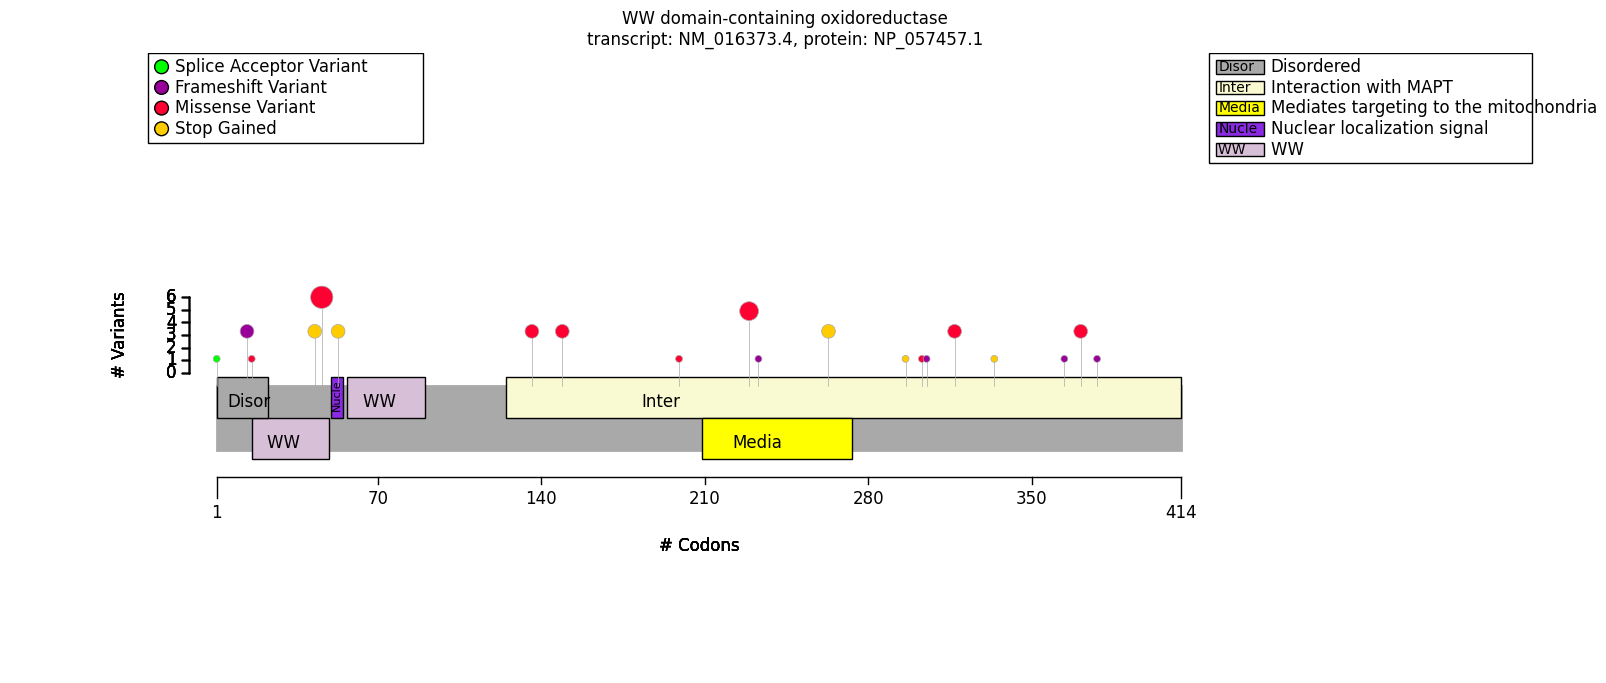

In [8]:
from gpsea.view import ProteinVisualizer

drawer = ProteinVisualizer()
_ = drawer.draw_fig(pvis=pvis)

## Allele report

In [9]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
report = viewer.process(cohort)
display(HTML(report))

Variant key,Variant (cDNA),Variant (protein),Effects,Count
16_78424953_78424953_A_C,c.689A>C,p.Gln230Pro,missense,4
16_78108454_78108454_C_A,c.139C>A,p.Pro47Thr,missense,4
16_78386858_78432751_--45894bp--_A,c.517_1056del,p.His173_Met352del,"splice acceptor, splice donor, splice donor 5th base, coding sequence, intronic",3
16_78386858_78425054_--38197bp--_A,c.517_791del,p.His173IlefsTer5,"splice acceptor, splice donor, splice donor 5th base, coding sequence, intronic",3
16_78164183_78164183_G_A,c.410G>A,p.Gly137Glu,"missense, splice region",2
16_78432649_78432649_C_T,c.953C>T,p.Ser318Leu,missense,2
16_78108455_78108455_C_G,c.140C>G,p.Pro47Arg,missense,2
16_78424868_78425054_--187bp--_A,c.607_791+1del,None,"splice acceptor, coding sequence",2
16_78108446_78108446_G_A,c.131G>A,p.Trp44Ter,stop gained,2
16_79211665_79211665_G_C,c.1114G>C,p.Gly372Arg,missense,2


# Configure genotype phenotype analysis

## Genotype predicate

Test Missense variants vs. the others.

<span style='color: red'>IMPORTANT - genotype predicate should be tailored to your analysis!</span>

In [10]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, ModeOfInheritancePredicate

is_missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
gt_predicate = ModeOfInheritancePredicate.autosomal_recessive(is_missense)

## Phenotype predicate

In [11]:
from gpsea.model import FeatureType
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

## MTC filter, MTC correction, and statistic

In [12]:
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter

mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

## Assemble the analysis

In [13]:
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

# Execute the analysis

In [14]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)

## Show MTC report

In [15]:
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
report = viewer.process(result)
display(HTML(report))

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,3
HMF02,Skipping term because no genotype has more than one observed HPO count,1
HMF04,Skipping term because all genotypes have same HPO observed proportions,32
HMF05,Skipping term because one genotype had zero observations,15
HMF06,Skipping term with less than 6 observations (not powered for 2x3),63
HMF08,Skipping general term,37


## Summarize the HPO terms

In [16]:
from gpsea.view import summarize_hpo_analysis

report = summarize_hpo_analysis(hpo=hpo, result=result)
report

What is the genotype group                         HOM_REF           HET  \
                                                     Count Percent Count   
Ataxia [HP:0001251]                                    0/4      0%   0/2   
Gait ataxia [HP:0002066]                               0/4      0%   0/2   
Abnormal electroretinogram [HP:0000512]                6/8     75%   0/4   
Generalized non-motor (absence) seizure [HP:000...    0/14      0%   0/7   
Cerebral atrophy [HP:0002059]                        10/16     62%   1/7   
Epileptic spasm [HP:0011097]                          6/14     43%   3/7   
Reduced eye contact [HP:0000817]                     12/14     86%   3/6   
Spasticity [HP:0001257]                                8/9     89%   3/6   
Narrow forehead [HP:0000341]                          3/10     30%   0/5   
Focal clonic seizure [HP:0002266]                     2/14     14%   3/7   
Bilateral tonic-clonic seizure with focal onset...    5/15     33%   2/7   
Upslanted palpebral fissure [HP:0000582]              2/10     20%   0/5   
Anteverted nares [HP:0000463]                         2/10     20%   0/5   
Short neck [HP:0000470]                               2/10     20%   0/5   
Micrognathia [HP:0000347]                             2/10     20%   0/5   
Round face [HP:0000311]                               1/10     10%   1/5   
Focal tonic seizure [HP:0011167]                      2/14     14%   0/7   
Uplifted earlobe [HP:0009909]                         3/10     30%   0/5   
Decreased fetal movement [HP:0001558]                 2/10     20%   1/5   
Hypokinesia [HP:0002375]                             12/14     86%   5/7   
Optic atrophy [HP:0000648]                            3/13     23%   1/7   
Thin corpus callosum [HP:0033725]                     9/14     64%   5/7   

What is the genotype group                                 BIALLELIC_ALT  \
                                                   Percent         Count   
Ataxia [HP:0001251]                                     0%           6/6   
Gait ataxia [HP:0002066]                                0%           4/4   
Abnormal electroretinogram [HP:0000512]                 0%           0/4   
Generalized non-motor (absence) seizure [HP:000...      0%           2/5   
Cerebral atrophy [HP:0002059]                          14%           3/5   
Epileptic spasm [HP:0011097]                           43%           0/5   
Reduced eye contact [HP:0000817]                       50%           4/5   
Spasticity [HP:0001257]                                50%           4/6   
Narrow forehead [HP:0000341]                            0%           0/5   
Focal clonic seizure [HP:0002266]                      43%           1/5   
Bilateral tonic-clonic seizure with focal onset...     29%           0/5   
Upslanted palpebral fissure [HP:0000582]                0%           0/5   
Anteverted nares [HP:0000463]                           0%           0/5   
Short neck [HP:0000470]                                 0%           0/5   
Micrognathia [HP:0000347]                               0%           0/5   
Round face [HP:0000311]                                20%           2/5   
Focal tonic seizure [HP:0011167]                        0%           1/5   
Uplifted earlobe [HP:0009909]                           0%           1/5   
Decreased fetal movement [HP:0001558]                  20%           0/5   
Hypokinesia [HP:0002375]                               71%           3/4   
Optic atrophy [HP:0000648]                             14%           0/2   
Thin corpus callosum [HP:0033725]                      71%           3/4   

What is the genotype group                                                     \
                                                   Percent Corrected p values   
Ataxia [HP:0001251]                                   100%           0.047619   
Gait ataxia [HP:0002066]                              100%           0.102564   
Abnormal electroretinogram